In [12]:
import numpy as np
from scipy.linalg import eigh, qr, null_space
import matplotlib.pyplot as plt
from scipy.sparse import kron, identity, csr_matrix, lil_matrix, dok_matrix, coo_matrix, issparse
from scipy.sparse.linalg import eigsh, eigs
from scipy.special import factorial, comb
from scipy.optimize import curve_fit
from qutip import Qobj, ptrace, entropy_vn, qeye, tensor
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from joblib import Parallel, delayed
from itertools import combinations
from collections import Counter
#from quspin.basis import spin_basis_1d, spin_basis_general
#import tenpy as tp

In [13]:
# spin-1/2 basis states + spin operators

# basis states for spin-1/2 system

# |up> state
ket_p = csr_matrix([[1], [0]])

# |down> state
ket_m = csr_matrix([[0], [1]])

# Spin-1/2 operators as sparse matrices
sx = csr_matrix([[0, 1], [1, 0]], dtype=np.complex128)
sy = csr_matrix([[0, -1j], [1j, 0]], dtype=np.complex128)
sz = csr_matrix([[1, 0], [0, -1]], dtype=np.complex128)

I = identity(2, format='csr', dtype=np.complex128)

# --- Vacuum state |W> ---
def W(L):
    state = csr_matrix((2**L, 1), dtype=np.complex128)

    for i in range(L):
        term = ket_p if i != 0 else ket_m
            # Start with first qubit

        for j in range(1,L):
            if j == i:
                term = kron(term, ket_p, format='csr')
            else:
                term = kron(term, ket_m, format='csr')

        state += term

    state /= np.sqrt(L)  # Normalize the state

    return state


def hamiltonian_xyW(L, J, alpha, h, bc):

    H = csr_matrix((2**L, 2**L), dtype=complex)
    
    # J term
    for i in range(1,L):
        hxx_term = 1
        for j in range(1,L+1):
            if j == i or j == i+1:
                hxx_term = kron(hxx_term, sx, format='csr')
            else:
                hxx_term = kron(hxx_term, I, format='csr')
        H -= J * hxx_term

    # alpha term
    for i in range(1,L):
        hyy_term = 1
        for j in range(1,L+1):
            if j == i or j == i+1:
                hyy_term = kron(hyy_term, sy, format='csr')
            else:
                hyy_term = kron(hyy_term, I, format='csr')
        H -= alpha * hyy_term

    # h term
    for i in range(1,L+1):
        hz_term = 1
        for j in range(1,L+1):
            if j == i:
                hz_term = kron(hz_term, sz, format='csr')
            else:
                hz_term = kron(hz_term, I, format='csr')
        H -= h * hz_term
    
    # For PBC, add the wraparound J and alpha terms
    if bc == 'pbc':
        hxx_wrap = 1
        hyy_wrap =1
        for j in range(1,L+1):
            if j == 1 or j == L:
                hxx_wrap = kron(hxx_wrap, sz, format='csr')
                hyy_wrap = kron(hyy_wrap, sz, format='csr')

            else:
                hxx_wrap = kron(hxx_wrap, I, format='csr')
                hyy_wrap = kron(hyy_wrap, I, format='csr')
        H -= J * hxx_wrap + alpha * hyy_wrap
    
    return H

In [14]:
# functions

def innermost_adjacent_indices(L, block_size):
    """
    Returns the indices of the innermost adjacent block of given size.
    For even L, the block is centered in the middle.
    """
    start = (L - block_size) // 2
    return list(range(start, start + block_size))

def all_adjacent_indices(L, block_size, bc):
    """
    Returns a list of all possible adjacent blocks of given size.
    Each block is represented as a list of indices.
    
    Args:
        L: system size  
        block_size: size of the block
        bc: boundary conditions ('obc' or 'pbc')
    """
    blocks = []
    
    if bc == 'obc':
        # Original OBC implementation
        for start in range(1, L - block_size + 1 + 1):
            blocks.append(list(range(start, start + block_size)))
    
    elif bc == 'pbc':
        # PBC implementation - sites wrap around
        for start in range(L):
            block = []
            for i in range(1, block_size + 1):
                block.append((start + i) % L)  # Wrap around using modulo
            blocks.append(block)
    
    else:
        raise ValueError("Boundary condition must be 'obc' or 'pbc'")
    
    return blocks


def ptrace_sparse(dm_sparse, keep, dims):
    """
    Compute the partial trace over arbitrary subsystems using sparse matrix operations.

    Args:
        dm_sparse (scipy.sparse matrix): Full density matrix of shape (D, D), where D = product(dims)
        keep (list of int): Subsystems to keep (indices, 0-indexed)
        dims (list of int): List of subsystem dimensions, e.g., [2]*n for n qubits

    Returns:
        scipy.sparse.csr_matrix: Reduced density matrix over kept subsystems
    """
    if not issparse(dm_sparse):
        raise ValueError("dm_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if dm_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])
    # Prepare output
    data = []
    row_idx = []
    col_idx = []

    # Precompute bit masks
    #def idx_to_bits(idx):
    #    return np.array(list(np.binary_repr(idx, width=n))).astype(int)

    def idx_to_subsys(idx, dims):
    #Convert flat index to tuple of subsystem indices for arbitrary dims
        subsys = []
        for d in reversed(dims):
            subsys.append(idx % d)
            idx //= d
        return np.array(subsys[::-1])
    

    dm_sparse = dm_sparse.tocoo()

    ''' for i, j, val in zip(dm_sparse.row, dm_sparse.col, dm_sparse.data):
        bi = idx_to_bits(i)
        bj = idx_to_bits(j)

        # Only sum terms where traced-out subsystems agree
        if np.all(bi[trace] == bj[trace]):
            # Extract kept bits and convert to reduced indices
            #print('condition met for i, j:', i, j)
            i_red_bits = bi[keep]
            j_red_bits = bj[keep]
            i_red = int("".join(i_red_bits.astype(str)), 2)
            j_red = int("".join(j_red_bits.astype(str)), 2)

            data.append(val)
            row_idx.append(i_red)
            col_idx.append(j_red)'''

    for i, j, val in zip(dm_sparse.row, dm_sparse.col, dm_sparse.data):
        bi = idx_to_subsys(i, dims)
        bj = idx_to_subsys(j, dims)

        if np.all(bi[trace] == bj[trace]):
            i_red = 0
            j_red = 0
            for k, pos in enumerate(keep):
                i_red = i_red * dims[pos] + bi[pos]
                j_red = j_red * dims[pos] + bj[pos]

            data.append(val)
            row_idx.append(i_red)
            col_idx.append(j_red)

    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()



def ptrace_sparse_parallel(dm_sparse, keep, dims, n_jobs=-1): # njobs to be removed if not using joblib
    """
    Compute the partial trace over arbitrary subsystems using sparse matrix operations.
    Parallelized over nonzero elements.
    """
    if not issparse(dm_sparse):
        raise ValueError("dm_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if dm_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])

    #def idx_to_bits(idx):
    #    return np.array(list(np.binary_repr(idx, width=n))).astype(int)

    def idx_to_subsys(idx, dims):
    #Convert flat index to tuple of subsystem indices for arbitrary dims.
        subsys = []
        for d in reversed(dims):
            subsys.append(idx % d)
            idx //= d
        return np.array(subsys[::-1])

    dm_sparse = dm_sparse.tocoo()

    #def process_entry(i,j,val):
    #    bi = idx_to_bits(i)
    #    bj = idx_to_bits(j)
    #    if np.all(bi[trace] == bj[trace]):
    #        i_red_bits = bi[keep]
    #        j_red_bits = bj[keep]
    #        i_red = int("".join(i_red_bits.astype(str)), 2)
    #        j_red = int("".join(j_red_bits.astype(str)), 2)
    #        return (val, i_red, j_red)
    #    else:
    #        return None

    def process_entry(i,j,val):
        bi = idx_to_subsys(i, dims)
        bj = idx_to_subsys(j, dims)

        if np.all(bi[trace] == bj[trace]):
            i_red = 0
            j_red = 0
            for k, pos in enumerate(keep):
                i_red = i_red * dims[pos] + bi[pos]
                j_red = j_red * dims[pos] + bj[pos]
            return (val, i_red, j_red)
        else:
            return None
        
    results = Parallel(n_jobs=n_jobs, prefer="processes")(
        delayed(process_entry)(i, j, val)
        for i, j, val in zip(dm_sparse.row, dm_sparse.col, dm_sparse.data)
    )
    results = [r for r in results if r is not None]

    #entries = zip(psi_sparse.row, psi_sparse.col, psi_sparse.data)
    #results = []
    #with ThreadPoolExecutor() as executor:
    #    for res in executor.map(process_entry, entries):
    #        if res is not None:
    #            results.append(res)'''
    
    if results:
        data, row_idx, col_idx = zip(*results)
    else:
        data, row_idx, col_idx = [], [], []

    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()

def ee_sparse(dm_sparse, L):
    """
    Computes the entanglement entropy of a state using sparse matrices in parallel.
    The state is assumed to be a vector in the Hilbert space of L qubits.
    """
    rhoA = ptrace_sparse(dm_sparse, list(range(L // 2)), [2] * L)
    eigvals = np.linalg.eigvalsh(rhoA.toarray())
    return -np.sum(eigvals * np.log(eigvals + 1e-12)).real  # Add small value to avoid log(0)

def ee_sparse_parallel(dm_sparse, L, n_jobs=-1):
    """
    Computes the entanglement entropy of a state using sparse matrices in parallel.
    The state is assumed to be a vector in the Hilbert space of L qubits.
    """
    rhoA = ptrace_sparse_parallel(dm_sparse, list(range(L // 2)), [2] * L, n_jobs=n_jobs)
    eigvals = np.linalg.eigvalsh(rhoA.toarray())
    return -np.sum(eigvals * np.log(eigvals + 1e-12)).real  # Add small value to avoid log(0)

def rdm_qutip(state, L, keep_qubits):
    rho = np.outer(state, state.conj())
    rho_qobj = Qobj(rho, dims=[[2] * L, [2] * L])
    rdm = ptrace(rho_qobj, keep_qubits)
    rdm_mat = rdm.full()
    eigvals = np.linalg.eigvalsh(rdm_mat)
    min_eigval = np.min(eigvals)
    # Rank: count nonzero eigenvalues (with tolerance)
    rank = np.sum(eigvals > 1e-12)
    return rdm, min_eigval, rank

def ee_qutip(state, L):
    rho = np.outer(state, state.conj())
    rho_qobj = Qobj(rho, dims=[[2] * L, [2] * L])
    rhoA = ptrace(rho_qobj, list(range(L//2)))
    return entropy_vn(rhoA)

In [15]:
'''
def partial_trace_qubit(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits."""
    keep_dims = np.prod([dims[i] for i in keep])
    trace_dims = np.prod([dims[i] for i in range(len(dims)) if i not in keep])
    rho = rho.reshape([keep_dims, trace_dims, keep_dims, trace_dims])
    return np.trace(rho, axis1=1, axis2=3).reshape([keep_dims, keep_dims])

def partial_trace_qubit_torch(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits using PyTorch."""
    keep_dims = torch.prod(torch.tensor([dims[i] for i in keep]))
    trace_dims = torch.prod(torch.tensor([dims[i] for i in range(len(dims)) if i not in keep]))
    rho = rho.view(keep_dims, trace_dims, keep_dims, trace_dims)
    # Compute the partial trace
    traced_rho = torch.zeros((keep_dims, keep_dims), dtype=rho.dtype)
    for i in range(trace_dims):
        traced_rho += rho[:, i, :, i]
    #return traced_rho.view(keep_dims, keep_dims)
    return traced_rho'''

def isket_numpy(arr):
    """
    Check if a NumPy array is a ket (column vector).

    Parameters:
    - arr: np.ndarray, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, np.ndarray):
        raise ValueError("Input must be a NumPy array")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_numpy(Q, sel, dims): # numpy function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using NumPy.

    Parameters:
    - Q: numpy object, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - numpy object, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = np.asarray(dims[0], dtype=np.int32).ravel()
    nd = len(rd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = np.array([sel])
    else:
        sel = np.asarray(sel)
    sel = list(np.sort(sel))
    
    # Dimensions of the subsystems to keep
    dkeep = (rd[sel]).tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(np.arange(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = (rd[qtrace]).tolist()
    
    # Reshape the density matrix or state vector
    rd = list(rd)
    if isket_numpy(Q):
        # Reshape and transpose for state vector
        vmat = (Q
                .reshape(rd)
                .transpose(sel + qtrace)
                .reshape([np.prod(dkeep), np.prod(dtrace)]))
        # Compute the reduced density matrix
        rhomat = vmat.dot(vmat.conj().T)
    else:
        # Reshape and transpose for density matrix
        rhomat = np.trace(Q
                          .reshape(rd + rd)
                          .transpose(qtrace + [nd + q for q in qtrace] +
                                     sel + [nd + q for q in sel])
                          .reshape([np.prod(dtrace),
                                    np.prod(dtrace),
                                    np.prod(dkeep),
                                    np.prod(dkeep)]))
    return rhomat


def ptrace_sparse(psi_sparse, keep, dims):
    """
    Compute the partial trace over arbitrary subsystems using sparse matrix operations.

    Args:
        psi_sparse (scipy.sparse matrix): Full density matrix of shape (D, D), where D = product(dims)
        keep (list of int): Subsystems to keep (indices, 0-indexed)
        dims (list of int): List of subsystem dimensions, e.g., [2]*n for n qubits

    Returns:
        scipy.sparse.csr_matrix: Reduced density matrix over kept subsystems
    """
    if not issparse(psi_sparse):
        raise ValueError("psi_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if psi_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])
    # Prepare output
    data = []
    row_idx = []
    col_idx = []

    # Precompute bit masks
    def idx_to_bits(idx):
        return np.array(list(np.binary_repr(idx, width=n))).astype(int)
    

    psi_sparse = psi_sparse.tocoo()
    for i, j, val in zip(psi_sparse.row, psi_sparse.col, psi_sparse.data):
        bi = idx_to_bits(i)
        bj = idx_to_bits(j)


        # Only sum terms where traced-out subsystems agree
        if np.all(bi[trace] == bj[trace]):
            # Extract kept bits and convert to reduced indices
            #print('condition met for i, j:', i, j)
            i_red_bits = bi[keep]
            j_red_bits = bj[keep]
            i_red = int("".join(i_red_bits.astype(str)), 2)
            j_red = int("".join(j_red_bits.astype(str)), 2)


            data.append(val)
            row_idx.append(i_red)
            col_idx.append(j_red)
    
    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()


def isket_torch(arr):
    """
    Check if a PyTorch tensor is a ket (column vector).

    Parameters:
    - arr: torch.Tensor, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, torch.Tensor):
        raise ValueError("Input must be a PyTorch tensor")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_torch(Q, sel, dims): # torch function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using PyTorch.

    Parameters:
    - Q: torch.Tensor, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - torch.Tensor, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = torch.tensor(dims[0], dtype=torch.int32).flatten()
    nd = len(rd)
    #print("rd", rd)
    #print("nd", nd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = torch.tensor([sel])
    else:
        sel = torch.tensor(sel)
    sel = torch.sort(sel).values.tolist()
    
    # Dimensions of the subsystems to keep
    dkeep = rd[sel].tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(range(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = rd[qtrace].tolist()
    
    # Reshape the density matrix or state vector
    rd = rd.tolist()
    if isket_torch(Q):
        # Reshape and transpose for state vector
        reshaped_Q = Q.reshape(rd)
        #print(reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(sel + qtrace)
        #print(transposed_Q.shape)
        vmat = transposed_Q.reshape([torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dtrace))])
        #print(vmat.shape)
        # Compute the reduced density matrix
        rhomat = vmat @ vmat.conj().T
        #print(rhomat.shape)
    else:
        # Reshape and transpose for density matrix
        reshaped_Q = Q.reshape(rd + rd)
        #print("reshaped_Q", reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(qtrace + [nd + q for q in qtrace] + sel + [nd + q for q in sel])
        #print("transposed_Q", transposed_Q.shape)
        reshaped_transposed_Q = transposed_Q.reshape([torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))])
        #print("reshaped_transposed_Q", reshaped_transposed_Q.shape)
        #rhomat = torch.trace(reshaped_transposed_Q)
        rhomat = torch.einsum('iikl->kl', reshaped_transposed_Q)
        # Trace out the first two dimensions
        #rhomat = torch.zeros((torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))), dtype=Q.dtype)
        #for i in range(reshaped_transposed_Q.shape[0]):
        #    for j in range(reshaped_transposed_Q.shape[1]):
        #        rhomat += reshaped_transposed_Q[i, j, :, :]
        #print("rhomat", rhomat.shape)
    return rhomat

def entanglement_entropy(psi, subsystem, total_size):

    '''Computes the bipartite entanglement entropy of a pure state.
    
    Parameters:
    psi : np.array
        The wavefunction (state vector) of the full system.
    subsystem_size : int
        The number of qubits in subsystem A.
    total_size : int
        The total number of qubits in the system.
    
    Returns:
    float
        The von Neumann entanglement entropy S_A.'''
    
    psi_matrix =  np.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_numpy(psi_matrix, subsystem, [[2]*total_size, [2]*total_size])  # Partial trace over B
    
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rho_A)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch(psi, subsystem, total_size):
    """
    Computes the bipartite entanglement entropy of a pure state using PyTorch.

    Parameters:
    - psi: torch.Tensor (complex), the wavefunction (state vector) of the full system.
    - subsystem_size: int, the number of qubits in subsystem A.
    - total_size: int, the total number of qubits in the system.

    Returns:
    - torch.Tensor (scalar), the von Neumann entanglement entropy S_A.
    """

    if not isinstance(psi, torch.Tensor):
        psi = torch.tensor(psi, dtype=torch.complex64)
    
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Compute the density matrix |psi><psi|
    psi_matrix = torch.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_torch(psi_matrix, subsystem, [[2] * total_size, [2] * total_size])  # Partial trace over B

    #rho_A = rho_A.to(dtype=torch.float64)
    
    # Compute eigenvalues of rho_A
    eigvals = torch.linalg.eigvalsh(rho_A)

    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigvals = eigvals[eigvals > 0]

    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -torch.sum(eigvals * torch.log2(eigvals))

    return entropy

def entanglement_entropy_qutip(psi, subsystem, total_size):
    
    # Convert the wavefunction to a QuTiP Qobj
    density_matrix = np.outer(psi, psi.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*total_size, [2]*total_size])

    rho_A = ptrace(density_matrix_qobj, subsystem)
    # Compute the von Neumann entropy S_A
    entropy = entropy_vn(rho_A, base=2)
    
    return entropy

def entanglement_entropy_np_ptrace(rdm):
    # rdm already computed and converted to numpy
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rdm)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch_ptrace(rdm):

    eigvals = torch.linalg.eigvalsh(rdm)
    eigvals = eigvals[eigvals > 0]
    entropy = -torch.sum(eigvals * torch.log2(eigvals))
    return entropy


def entanglement_entropy_qutip_torch(psi, N):
    """
    Compute the von Neumann entanglement entropy using qutip.

    Parameters:
    - psi: torch.Tensor (complex), state vector of a quantum system.
    - N: int, total number of qubits.

    Returns:
    - torch.Tensor (scalar), von Neumann entropy.
    """
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Convert PyTorch tensor to NumPy for QuTiP
    psi_np = psi.detach().numpy()

    rho_np = np.outer(psi_np, psi_np.conj())
    rho_qobj = Qobj(rho_np, dims=[[2] * N, [2] * N])

    rho_A = ptrace(rho_qobj, list(range(N // 2)))

    # Compute von Neumann entropy
    entropy = entropy_vn(rho_A, base=2)  # Compute in log base 2

    # Convert back to PyTorch tensor to allow gradient flow
    return torch.tensor(entropy, dtype=torch.float32, requires_grad=True)

#######################################################################################################################

# Define the linear combination function - numpy
def linear_combination_np(coeffs, psis):
    # Ensure psis are numpy tensors
    psi_np = [np.array(psi) for psi in psis]
    # Compute the linear combination in PyTorch
    psi = sum(c * psi for c, psi in zip(coeffs, psis))
    
    return psi

# Define the linear combination function - torch
def linear_combination(coeffs, psis):
    # Ensure psis are PyTorch tensors
    psis_torch = [torch.tensor(psi, dtype=torch.complex64) if not isinstance(psi, torch.Tensor) else psi for psi in psis]
    
    # Compute the linear combination in PyTorch
    psi_torch = sum(c * psi for c, psi in zip(coeffs, psis_torch))
    
    return psi_torch

# Define the linear combination function - torch but after computing the ptrace of outer products of scars
def linear_combination_outer(coeffs, outs):
    # Ensure outs are PyTorch tensors
    outs_torch = [torch.tensor(out, dtype=torch.complex64) if not isinstance(out, torch.Tensor) else out for out in outs]
    torch_coeffs = torch.tensor(coeffs, dtype=torch.complex64)

    # Compute the PyTorch tensor of out_coeffs which is the product of all possible combinations of c_i^* times c_j
    out_coeffs = torch.zeros((len(torch_coeffs), len(torch_coeffs)), dtype=torch.complex64)
    for i in range(len(torch_coeffs)):
        for j in range(len(torch_coeffs)):
            out_coeffs[i, j] = torch.conj(torch_coeffs[i]) * torch_coeffs[j]
    
    # Compute the linear combination in PyTorch
    lin_torch = sum(out_coeffs[i, j] * outs_torch[i] for i in range(len(coeffs)) for j in range(len(coeffs)))
    
    return lin_torch

######################################################

# Function to apply permutation to a given spin configuration
def apply_permutation(state_bits, N, perm):
    new_bits = [0] * N
    for i in range(N):
        new_bits[perm[i]] = state_bits[i]  # Map value at index i to perm[i]
    return new_bits

# Function to convert an index to its binary representation
def index_to_binary(index, num_qubits):
    return format(index, f'0{num_qubits}b')

In [16]:
Ltar = [14, 16, 18, 20, 22, 24, 26]  # Target system sizes
W_states = [W(Lt) for Lt in Ltar]

# Convert each dimer state to density matrix and calculate entanglement entropy
dimer_ee_tar = []
for i, Lt in enumerate(tqdm(Ltar)):
    w_sparse = csr_matrix(W_states[i].reshape(-1, 1))
    density_matrix = w_sparse @ w_sparse.getH()
    ee = ee_sparse_parallel(density_matrix, Lt, n_jobs=-1)
    dimer_ee_tar.append(ee)

100%|██████████| 7/7 [01:29<00:00, 12.80s/it]


In [17]:
print(dimer_ee_tar)

[np.float64(0.6931471805579476), np.float64(0.6931471805579438), np.float64(0.6931471805579456), np.float64(0.6931471805579446), np.float64(0.6931471805579474), np.float64(0.693147180557946), np.float64(0.693147180557945)]


In [18]:
L = 18 # number of sites -  it has to be even
bc = 'obc'  # boundary condition, can be 'obc' or 'pbc'

innermost_2 = innermost_adjacent_indices(L, 2)
innermost_3 = innermost_adjacent_indices(L, 3)
innermost_4 = innermost_adjacent_indices(L, 4)

adjacent_2 = all_adjacent_indices(L, 2, bc)
adjacent_3 = all_adjacent_indices(L, 3, bc)
adjacent_4 = all_adjacent_indices(L, 4, bc)

print("All adjacent 2-site blocks:", adjacent_2)
print("All adjacent 3-site blocks:", adjacent_3)
print("All adjacent 4-site blocks:", adjacent_4)

All adjacent 2-site blocks: [[1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11], [11, 12], [12, 13], [13, 14], [14, 15], [15, 16], [16, 17], [17, 18]]
All adjacent 3-site blocks: [[1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8], [7, 8, 9], [8, 9, 10], [9, 10, 11], [10, 11, 12], [11, 12, 13], [12, 13, 14], [13, 14, 15], [14, 15, 16], [15, 16, 17], [16, 17, 18]]
All adjacent 4-site blocks: [[1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6], [4, 5, 6, 7], [5, 6, 7, 8], [6, 7, 8, 9], [7, 8, 9, 10], [8, 9, 10, 11], [9, 10, 11, 12], [10, 11, 12, 13], [11, 12, 13, 14], [12, 13, 14, 15], [13, 14, 15, 16], [14, 15, 16, 17], [15, 16, 17, 18]]


In [19]:
W_state = W(L) 
print(f"state dimension for L={L}: {W_state.shape}")

W_sparse = csr_matrix(W_state.reshape(-1, 1))  # Convert to sparse column vector
density_matrix_sparse = W_sparse @ W_sparse.getH()  # Outer product to form density matrix
print("Number of non-zero elements of dm:", np.sum(np.abs(density_matrix_sparse.data) > 1e-16))    #Trace out qubits using qutip partial trace

'''# Calculate RDMs for all possible adjacent 2, 3, 4 site blocks
for block_size, all_blocks in zip([2, 3, 4], [adjacent_2, adjacent_3, adjacent_4]):
    print(f"\nAll possible RDMs for block size {block_size}:")
    for block_indices in tqdm(all_blocks):
        rdm = ptrace_sparse_parallel(density_matrix_sparse, block_indices, [2]*L, n_jobs=-1) # Use the custom ptrace_sparse function
        # Find the minimum eigenvalue of the traced-out density matrix
        eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())
        rank = np.linalg.matrix_rank(rdm.toarray())
        min_eigenvalue = np.min(eigenvalues_traced)
        print(f"Block {block_indices}: min eigenvalue = {min_eigenvalue}, rank = {rank}")'''
rdm = ptrace_sparse_parallel(density_matrix_sparse, adjacent_4[0], [2]*L, n_jobs=-1) # Use the custom ptrace_sparse function
# Find the minimum eigenvalue of the traced-out density matrix
eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())
rank = np.linalg.matrix_rank(rdm.toarray())
min_eigenvalue = np.min(eigenvalues_traced)
print(f"min eigenvalue = {min_eigenvalue}, rank = {rank}")

state dimension for L=18: (262144, 1)
Number of non-zero elements of dm: 324
min eigenvalue = -1.387778780781447e-17, rank = 2


In [ ]:
# All eigenvalues of H
# Compute all eigenvalues and corresponding eigenvectors
L=12
H = hamiltonian_xyW(L, J=1.0, alpha=1.0, h=1.0, bc='pbc')
eigenvalues, eigenvectors = np.linalg.eigh(H.toarray())

print(f"Eigenvalues of H: {np.sort(eigenvalues)}")

# Count the number of (near-)zero components in each eigenvector
zero_threshold = 1e-16
zero_counts = []
for i in range(eigenvectors.shape[1]):
    num_zeros = np.sum(np.abs(eigenvectors[:, i]) < zero_threshold)
    zero_counts.append(num_zeros)
    print(f"Eigenvector {i}: {num_zeros} components < {zero_threshold}")

# Optionally, print a summary
print("Zero count distribution:", Counter(zero_counts))

# Check if each eigenvector is complex or real
for i in range(eigenvectors.shape[1]):
    vec = eigenvectors[:, i]
    if np.any(np.abs(vec.imag) > 1e-14):
        print(f"Eigenvector {i} is complex.")
    #else:
    #    print(f"Eigenvector {i} is real.")

Eigenvalues of H: [-18.05529258 -17.96572556 -17.28943397 ...  16.56563733  16.6738405
  16.99564831]
Eigenvector 0: 3876 components < 1e-06
Eigenvector 1: 3603 components < 1e-06
Eigenvector 2: 4030 components < 1e-06
Eigenvector 3: 3876 components < 1e-06
Eigenvector 4: 3616 components < 1e-06
Eigenvector 5: 3308 components < 1e-06
Eigenvector 6: 4036 components < 1e-06
Eigenvector 7: 3876 components < 1e-06
Eigenvector 8: 4030 components < 1e-06
Eigenvector 9: 3876 components < 1e-06
Eigenvector 10: 3601 components < 1e-06
Eigenvector 11: 3876 components < 1e-06
Eigenvector 12: 3601 components < 1e-06
Eigenvector 13: 4084 components < 1e-06
Eigenvector 14: 3306 components < 1e-06
Eigenvector 15: 4030 components < 1e-06
Eigenvector 16: 3616 components < 1e-06
Eigenvector 17: 3936 components < 1e-06
Eigenvector 18: 4084 components < 1e-06
Eigenvector 19: 3306 components < 1e-06
Eigenvector 20: 4036 components < 1e-06
Eigenvector 21: 3176 components < 1e-06
Eigenvector 22: 3876 compone

100%|██████████| 4096/4096 [21:26<00:00,  3.18it/s]
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


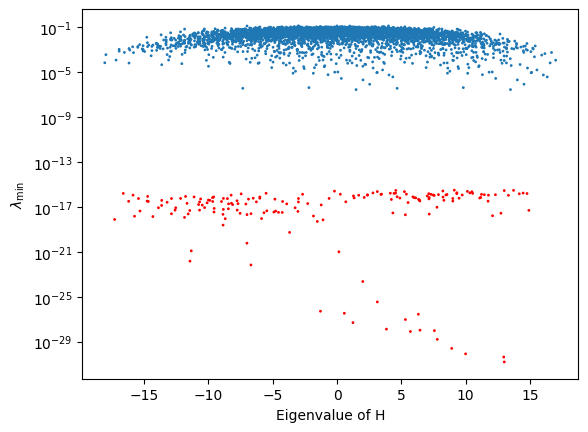

Indices of red points: [2, 6, 8, 13, 15, 18, 20, 27, 30, 31, 36, 41, 47, 52, 54, 62, 76, 77, 82, 84, 99, 112, 119, 122, 124, 132, 134, 141, 147, 169, 177, 178, 184, 187, 208, 219, 226, 237, 252, 254, 262, 265, 267, 309, 331, 332, 336, 337, 349, 369, 376, 378, 396, 399, 415, 456, 457, 464, 479, 490, 543, 556, 557, 570, 600, 604, 626, 671, 709, 711, 733, 758, 793, 800, 896, 917, 927, 964, 1032, 1037, 1097, 1153, 1241, 1294, 1298, 1300, 1382, 1473, 1578, 1650, 1707, 1721, 1757, 1877, 1984, 2065, 2089, 2170, 2199, 2342, 2351, 2365, 2455, 2533, 2560, 2620, 2622, 2721, 2796, 2797, 2869, 2880, 2962, 3022, 3039, 3066, 3088, 3106, 3108, 3131, 3176, 3248, 3260, 3261, 3278, 3309, 3336, 3371, 3385, 3401, 3436, 3439, 3447, 3451, 3454, 3544, 3560, 3561, 3566, 3567, 3591, 3618, 3629, 3633, 3655, 3656, 3669, 3706, 3709, 3714, 3736, 3742, 3781, 3790, 3791, 3805, 3827, 3828, 3847, 3862, 3881, 3884, 3892, 3908, 3914, 3924, 3958, 3963, 3968, 3984, 3994, 3995, 4006, 4015, 4031, 4036, 4040, 4041, 4052, 4058

In [21]:
# rdm - numpy

min_eigenvalues_np = []
min_rdms_np =[]
rdm_eigenvalues_np = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())

    # Trace out qubits
    traced_out_density_matrix = ptrace_numpy(density_matrix, [3,4,5], [[2]*L, [2]*L])

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced) 
    min_eigenvalues_np.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms_np.append(traced_out_density_matrix) #store the scarred rdms - step needed for optimization
        rdm_eigenvalues_np.append(eigenvalues_traced) #store the eigenvalues of the scarred rdms

# numpy

# Define the threshold
threshold = 1e-16
min_eigenvalues_np = np.array(min_eigenvalues_np)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues_np if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues_np), color=colors, s=1)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")
plt.show()

# Find indices of red points - numpy
red_indices_np = [i for i, y in enumerate(min_eigenvalues_np) if y < threshold]
print(f'Indices of red points: {red_indices_np}')

red_eigenvectors_np = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices_np):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues_np[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms_np[i])}')
    red_eigenvectors_np.append(eigenvectors[:, ind])

#for i in range(len(red_indices_np)):
#    for j in range(len(red_indices_np)):
#        idx1, idx2 = red_indices_np[i], red_indices_np[j]
#        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
#        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")

# Count entries of rdm_eigenvalues_np[i] - eigenvalues of the scarred rdms - that are non-zero
counts_np = [np.sum(eigenvalues > 1e-16) for eigenvalues in rdm_eigenvalues_np]
print(f'Counts of non-zero eigenvalues of the scarred rdms: {counts_np}')

100%|██████████| 4096/4096 [28:38<00:00,  2.38it/s]


Entropies of red points:
Index: 2, Entropy: 0.6806456330523264
Index: 6, Entropy: 0.8976870911988488
Index: 8, Entropy: 0.6275818326414425
Index: 13, Entropy: 0.6540708733389374
Index: 15, Entropy: 0.7465660773217881
Index: 18, Entropy: 0.09486595371605065
Index: 20, Entropy: 0.319021288669606
Index: 27, Entropy: 0.5985624063622226
Index: 30, Entropy: 0.8475749767339086
Index: 31, Entropy: 0.6975769128390197
Index: 36, Entropy: 0.5220489738303531
Index: 41, Entropy: -0.0
Index: 47, Entropy: 0.26793497818765605
Index: 52, Entropy: 0.8214031001072728
Index: 54, Entropy: 0.8135320846747494
Index: 62, Entropy: 0.48488561575205125
Index: 76, Entropy: 0.5977602250257747
Index: 77, Entropy: 0.48738790546437394
Index: 82, Entropy: 0.7612738170524539
Index: 84, Entropy: 0.775270753547638
Index: 99, Entropy: 0.3885772046505103
Index: 112, Entropy: 0.8825709238737082
Index: 119, Entropy: 0.44609499820825194
Index: 122, Entropy: 0.5806314129076091
Index: 124, Entropy: 0.8367363967447352
Index: 132

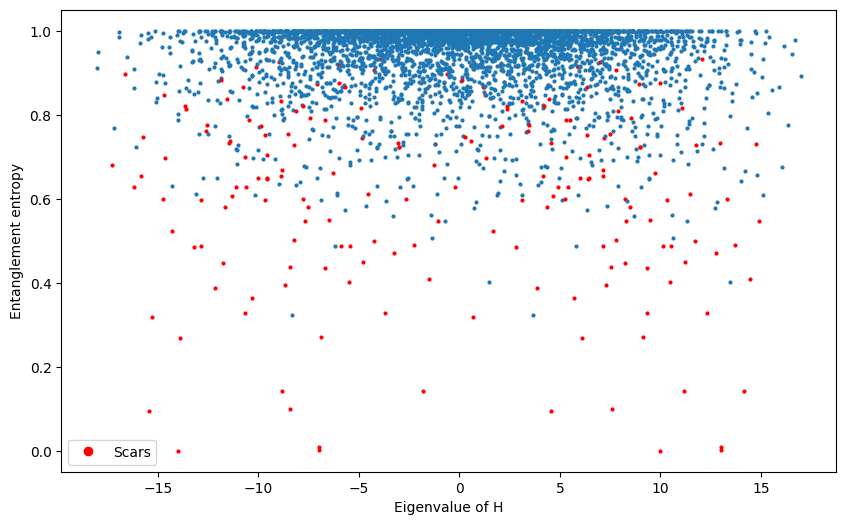

In [22]:
numpy_entropies = [entanglement_entropy(eigenvectors[:, i], L//2, L) for i in tqdm(range(eigenvectors.shape[1]))]
# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices_np:
    print(f'Index: {i}, Entropy: {numpy_entropies[i]}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=2)

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
plt.legend()
plt.show()